# 环境说明

In [10]:
!python -V

Python 3.11.5


In [21]:
import sklearn
import pandas
import numpy
import matplotlib
import statsmodels
import scipy

In [22]:
sklearn.__version__

'1.3.0'

In [23]:
pandas.__version__

'2.0.3'

In [24]:
numpy.__version__

'1.24.3'

In [25]:
matplotlib.__version__

'3.7.2'

In [26]:
statsmodels.__version__

'0.14.0'

In [27]:
scipy.__version__

'1.11.1'

# 代码实现

In [28]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score
from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
df = pd.read_csv("data/train.csv")

In [3]:
df.head()

,Age,Blood_Sugar,Blood_Pressure,Weight,Heart_Disease
0,58,99.975461,106.328124,62.448684,0
1,71,93.609515,134.190672,67.875853,0
2,48,119.131949,115.773278,49.263101,0
3,34,98.626509,117.651983,93.111787,0
4,62,114.056088,119.456831,71.043221,0


In [4]:
label_name = 'Heart_Disease'

In [5]:
X = df.drop(label_name, axis=1)
y = df[label_name]

In [6]:
# 添加常数列（截距项）到特征中
X_ = sm.add_constant(X)

# 拟合逻辑回归模型
model = sm.Logit(y, X_)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.022594
         Iterations 14


In [7]:
# 输出模型摘要
print(result.summary())

# 进行预测（概率值）
y_pred_prob = result.predict(X_)
# 将概率值转化为0/1预测类别，使用阈值0.5
y_pred_class = (y_pred_prob > 0.5).astype(int)
# 计算准确率
accuracy = accuracy_score(y, y_pred_class)
print(f"准确率: {accuracy:.4f}")

# 计算AUC（曲线下面积）
auc = roc_auc_score(y, y_pred_prob)
print(f"AUC: {auc:.4f}")

                           Logit Regression Results                           
Dep. Variable:          Heart_Disease   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            4
Date:                Mon, 24 Feb 2025   Pseudo R-squ.:                  0.8405
Time:                        15:00:14   Log-Likelihood:                -22.594
converged:                       True   LL-Null:                       -141.63
Covariance Type:            nonrobust   LLR p-value:                 2.421e-50
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -109.6707     24.800     -4.422      0.000    -158.278     -61.064
Age                0.4953      0.112      4.437      0.000       0.277       0.714
Blood_Sugar        0.5558      0.123

# Apparent计算

In [8]:
y_true, y_prob = y, y_pred_prob

## 预测概率采样

In [9]:
import numpy as np

n = len(y_prob)  
p = np.sort(y_prob)  
predy = np.linspace(p[4], p[n-5], num=50)  

In [10]:
predy[:5]

array([6.48726475e-24, 2.04054528e-02, 4.08109056e-02, 6.12163585e-02,
       8.16218113e-02])

## lowess平滑

lowess（局部加权回归）是 R 语言中用于平滑数据的一个函数。它通过对数据点使用局部加权回归（Locally Weighted Scatterplot Smoothing, LOWESS）方法来创建平滑的曲线，从而使得原始数据的噪声得到平滑处理，并揭示出数据的趋势或模式。

In [11]:
smo = lowess(endog=y_true, exog=y_prob
                  ,frac=2/3 
                  ,it=0
                  ,delta=(max(y_prob) - min(y_prob)) * 0.01
                 )  

## 插值填补

In [13]:
from scipy.interpolate import interp1d
interp_function = interp1d(smo[:, 0], smo[:, 1], kind='linear', fill_value='extrapolate', assume_sorted=False)
cal = interp_function(predy)

In [16]:
cal

array([0.        , 0.        , 0.03531016, 0.09656184, 0.18143783,
       0.25748856, 0.25862486, 0.24845049, 0.24652479, 0.23457752,
       0.21594259, 0.19028547, 0.18927053, 0.18825559, 0.18724064,
       0.19566589, 0.20483262, 0.21312489, 0.22096365, 0.22942596,
       0.2469134 , 0.27208035, 0.30843837, 0.34210236, 0.37393269,
       0.40576302, 0.43759335, 0.46942367, 0.501254  , 0.52806615,
       0.55233635, 0.57662434, 0.6009373 , 0.62525027, 0.64956324,
       0.6738762 , 0.69818917, 0.72281366, 0.74789432, 0.77313713,
       0.79854618, 0.82413325, 0.84989105, 0.87594446, 0.90199787,
       0.92805128, 0.95424958, 0.98060051, 1.00703136, 1.03353091])

## Apparent作图

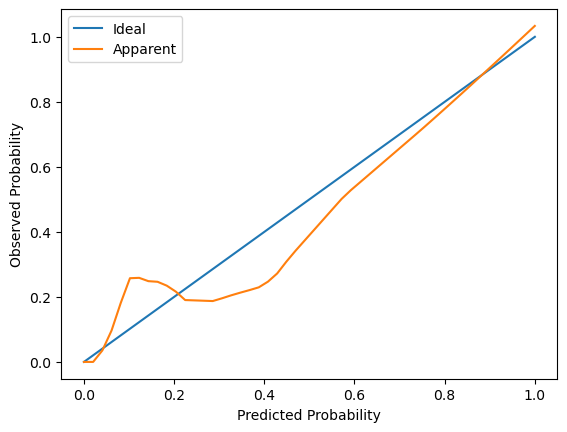

In [15]:
# "Ideal" 理想校准曲线 (y=x)
ideal_line = [0, 1]
plt.figure()
# 开始画图
# Ideal (理想曲线)
plt.plot(ideal_line, ideal_line, label='Ideal')
# Apparent (表观曲线)
plt.plot(predy, cal, label='Apparent')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.legend()

## 校准曲线采样